# Weather-guided Earth Surface Forecasting with Eathformer

In this tutorial, we will demonstrate how to apply [Earthformer](https://assets.amazon.science/89/ad/cb9c23dd4bb69b8e03bbbecdb4b8/earthformer-exploring-space-time-transformers-for-earth-system-forecasting.pdf) for Earth surface forecasting with the [EarthNet2021](https://arxiv.org/pdf/2104.10066.pdf) dataset. The goal of the task is to predict the future Earth surface based on the meterological forecasting results. EarthNet2021 contains Sentinel-2 satellite imagery at the 20 m resolution as well as the topography and mesoscale (1.28 km) meteorological variables. The future Earth surface can reflect the potential agricultural output and the ecosystem health. We will show how Earthformer can help predict the land surface in the future 100 days (5-daily prediction) based on the land surface in the past 50 days.

## Load and Visualize EarthNet2021

For purpose of demonstration, we download a small set of the IID-test split of EarthNet2021.

In [1]:
!python3 -m pip install -q earthnet

import earthnet.download_links
import earthnet.download
from earthnet.download import DownloadProgressBar
import earthnet as en

class NewDownloadProgressBar(DownloadProgressBar):
    def __init__(self, **kwargs):
        super().__init__(disable=True, **kwargs)

earthnet.download.DownloadProgressBar = NewDownloadProgressBar
earthnet.download_links.DOWNLOAD_LINKS["iid"] = earthnet.download_links.DOWNLOAD_LINKS["iid"][:1]
print(earthnet.download_links.DOWNLOAD_LINKS["iid"])
en.Downloader.get("./datasets/earthnet2021", "iid")

[['iid_000.tar.gz', 'https://owncloud.gwdg.de/index.php/s/yHwDqblRPdFnEym/download', '1884a24f3a9261cc1f4fe1b2310f66b17c689af20e38bd176734815a2f84c456']]
iid


  0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]

Downloading...
Downloaded!
Asserting SHA256 Hash.
SHA256 Hash is correct!
Extracting tarball...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.04s/it]

Extracted!
Deleting tarball...


In [2]:
from omegaconf import OmegaConf
from earthformer.datasets.earthnet.earthnet_dataloader import EarthNet2021LightningDataModule, EarthNet2021TestDataset
from pytorch_lightning import Trainer, seed_everything, loggers as pl_loggers
from earthformer.datasets.earthnet.visualization import vis_earthnet_seq
import numpy as np

config_file = "./earthformer_earthnet_v1.yaml"
config = OmegaConf.load(open(config_file, "r"))
in_len = config.layout.in_len
out_len = config.layout.out_len

seed = config.optim.seed
dataset_cfg = OmegaConf.to_object(config.dataset)

seed_everything(seed, workers=True)

micro_batch_size = 1

earthnet_iid_testset = EarthNet2021TestDataset(subset_name="iid",
                                               data_dir="./datasets/earthnet2021/iid_test_split",
                                               layout=config.dataset.layout,
                                               static_layout=config.dataset.static_layout,
                                               highresstatic_expand_t=config.dataset.highresstatic_expand_t,
                                               mesostatic_expand_t=config.dataset.mesostatic_expand_t,
                                               meso_crop=None,
                                               fp16=False)

total_num_test_samples = len(earthnet_iid_testset)
print("The total number of test samples is", total_num_test_samples)

/home/ubuntu/.conda/envs/xjshi_dev/lib/python3.9/site-packages/horovod/common/util.py:258: UserWarning: Framework pytorch installed with version 1.12.0 but found version 1.12.1+cu116.
             This can result in unexpected behavior including runtime errors.
             Reinstall Horovod using `pip install --no-cache-dir` to build with the new version.
  warnings.warn(get_version_mismatch_message(name, version, installed_version))
/home/ubuntu/.conda/envs/xjshi_dev/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Global seed set to 0


The total number of test samples is 4219


Here, the dataset contains four components:

- **"highresdynamic"**: The Sentinel-2 landcover data. The bands are "blue", "green", "red", "nir", "cloud". We will use the first four bands in this problem. This dataset will be 5-daily, meaning that there will be one observation in 5 days. The size of each frame is 128x128.

- **"highresstatic"**: The elevation of the Sentinel-2 data.

- **"mesodynamic"**: The mesoscale weather data. The bands are "precipitation", "pressure", "temp mean", "temp min", "temp max". The data will be daily and the size of each frame is 80x80.

- **"mesostatic"**: The elevation of the mesoscale weather data.

We will use the first 10 frames of **"highresdynamics"** and the auxiliary data (**highresstatic**, **mesodynamic**, **mesostatic**) to predict the future 20 frames of **"highresdynamics"**. This is equivalent to using the land surface data in the previous 50 days to predict the land surface data in the coming 100 days.

Let's first visualize some data samples:

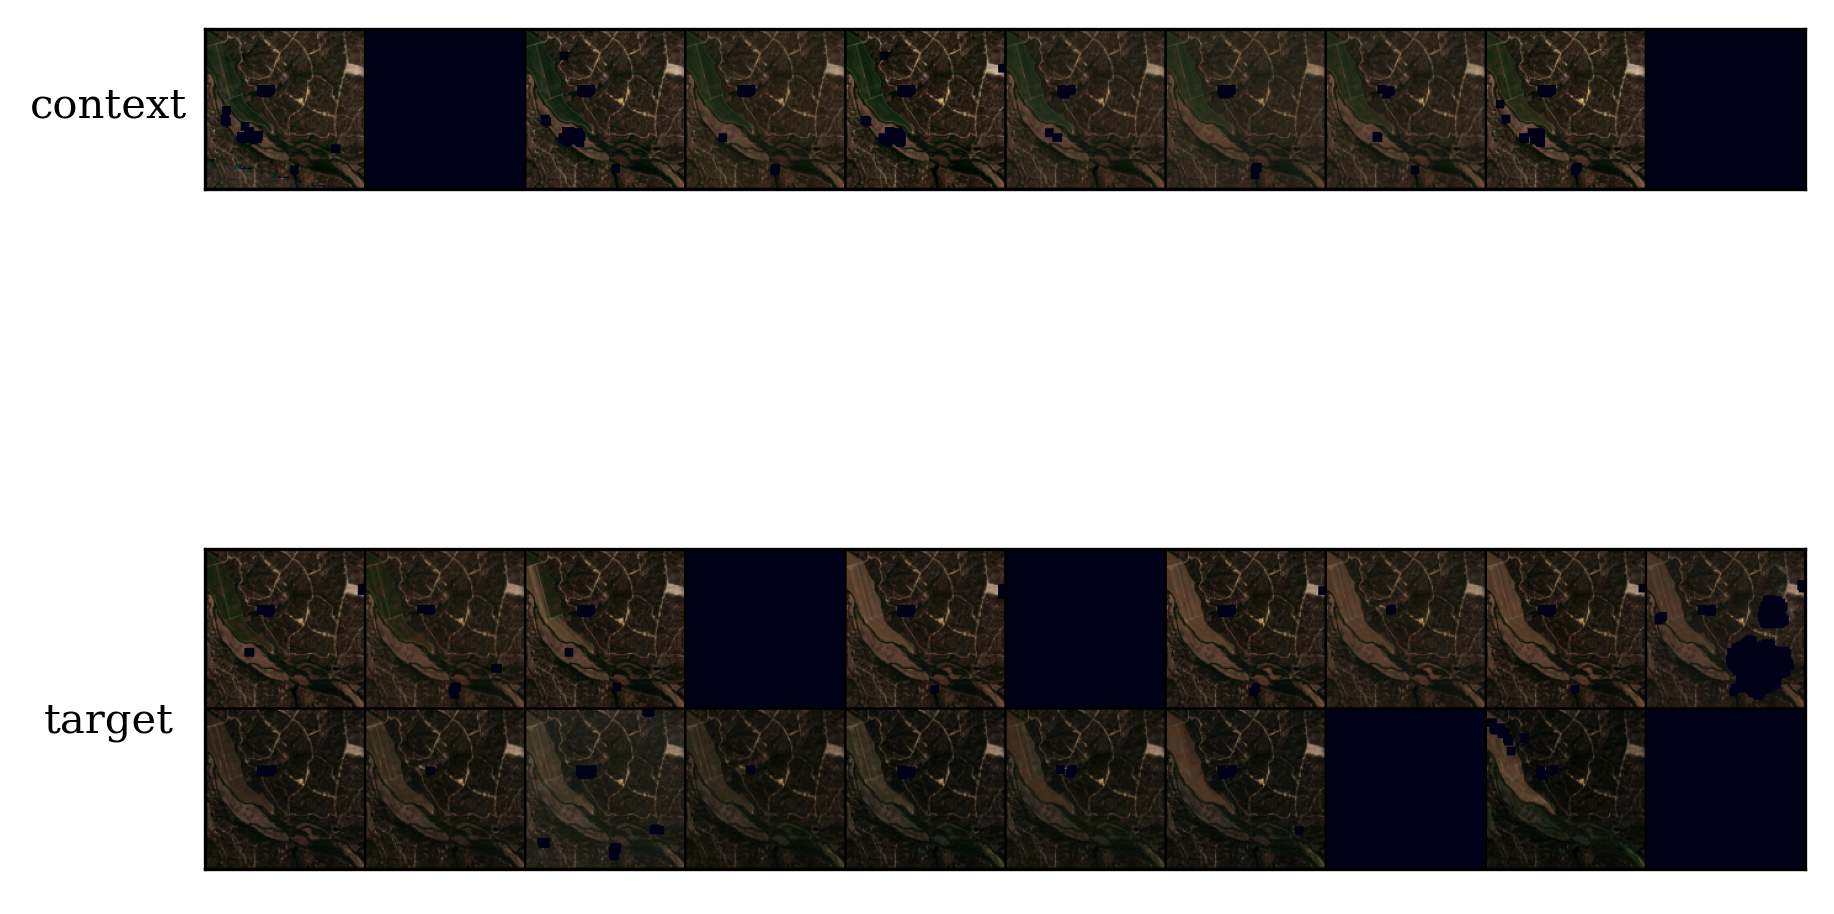

In [3]:
idx = 20

def process_sample(sample):
    # High-resolution Earth surface data. The channels are [blue, green, red, nir, cloud]
    highresdynamic = sample['highresdynamic']
    highresstatic = sample['highresstatic']

    # The meso-scale data. The channels are ["precipitation", "pressure", "temp mean", "temp min", "temp max"]
    mesodynamic = sample['mesodynamic']
    mesostatic = sample['mesostatic']

    highresdynamic = np.nan_to_num(highresdynamic, nan=0.0, posinf=1.0, neginf=0.0)
    highresdynamic = np.clip(highresdynamic, a_min=0.0, a_max=1.0)
    mesodynamic = np.nan_to_num(mesodynamic, nan=0.0)
    highresstatic = np.nan_to_num(highresstatic, nan=0.0)
    mesostatic = np.nan_to_num(mesostatic, nan=0.0)
    return highresdynamic, highresstatic, mesodynamic, mesostatic

highresdynamic, highresstatic, mesodynamic, mesostatic = process_sample(earthnet_iid_testset[idx])

highresdynamic_in, highresdynamic_out = highresdynamic[:in_len, ...], highresdynamic[in_len:, ...]
highresstatic_in, highresstatic_out = highresstatic[:in_len, ...], highresstatic[in_len:, ...]
mesodynamic_in, mesodynamic_out = mesodynamic[:in_len, ...], mesodynamic[in_len:, ...]
mesostatic_in, mesostatic_out = mesostatic[:in_len, ...], mesostatic[in_len:, ...]

fig_rgb = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                       target_np=np.expand_dims(highresdynamic_out, axis=0),
                       pred_np=None,
                       layout='N' + config.dataset.layout)

Following is the NDVI index calculated via the formula: $NDVI=\frac{I_{\text{NIR}} - I_{\text{red}}}{I_{\text{NIR}} + I_{\text{red}}}$. It quantifies vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). See the following image from NASA for an illustration of NDVI:

![Image courtesy of NASA.](https://gisgeography.com/wp-content/uploads/2017/08/ndvi-example.jpg)

Here, we will also plot the EarthNet2021 sample visualized via NDVI.

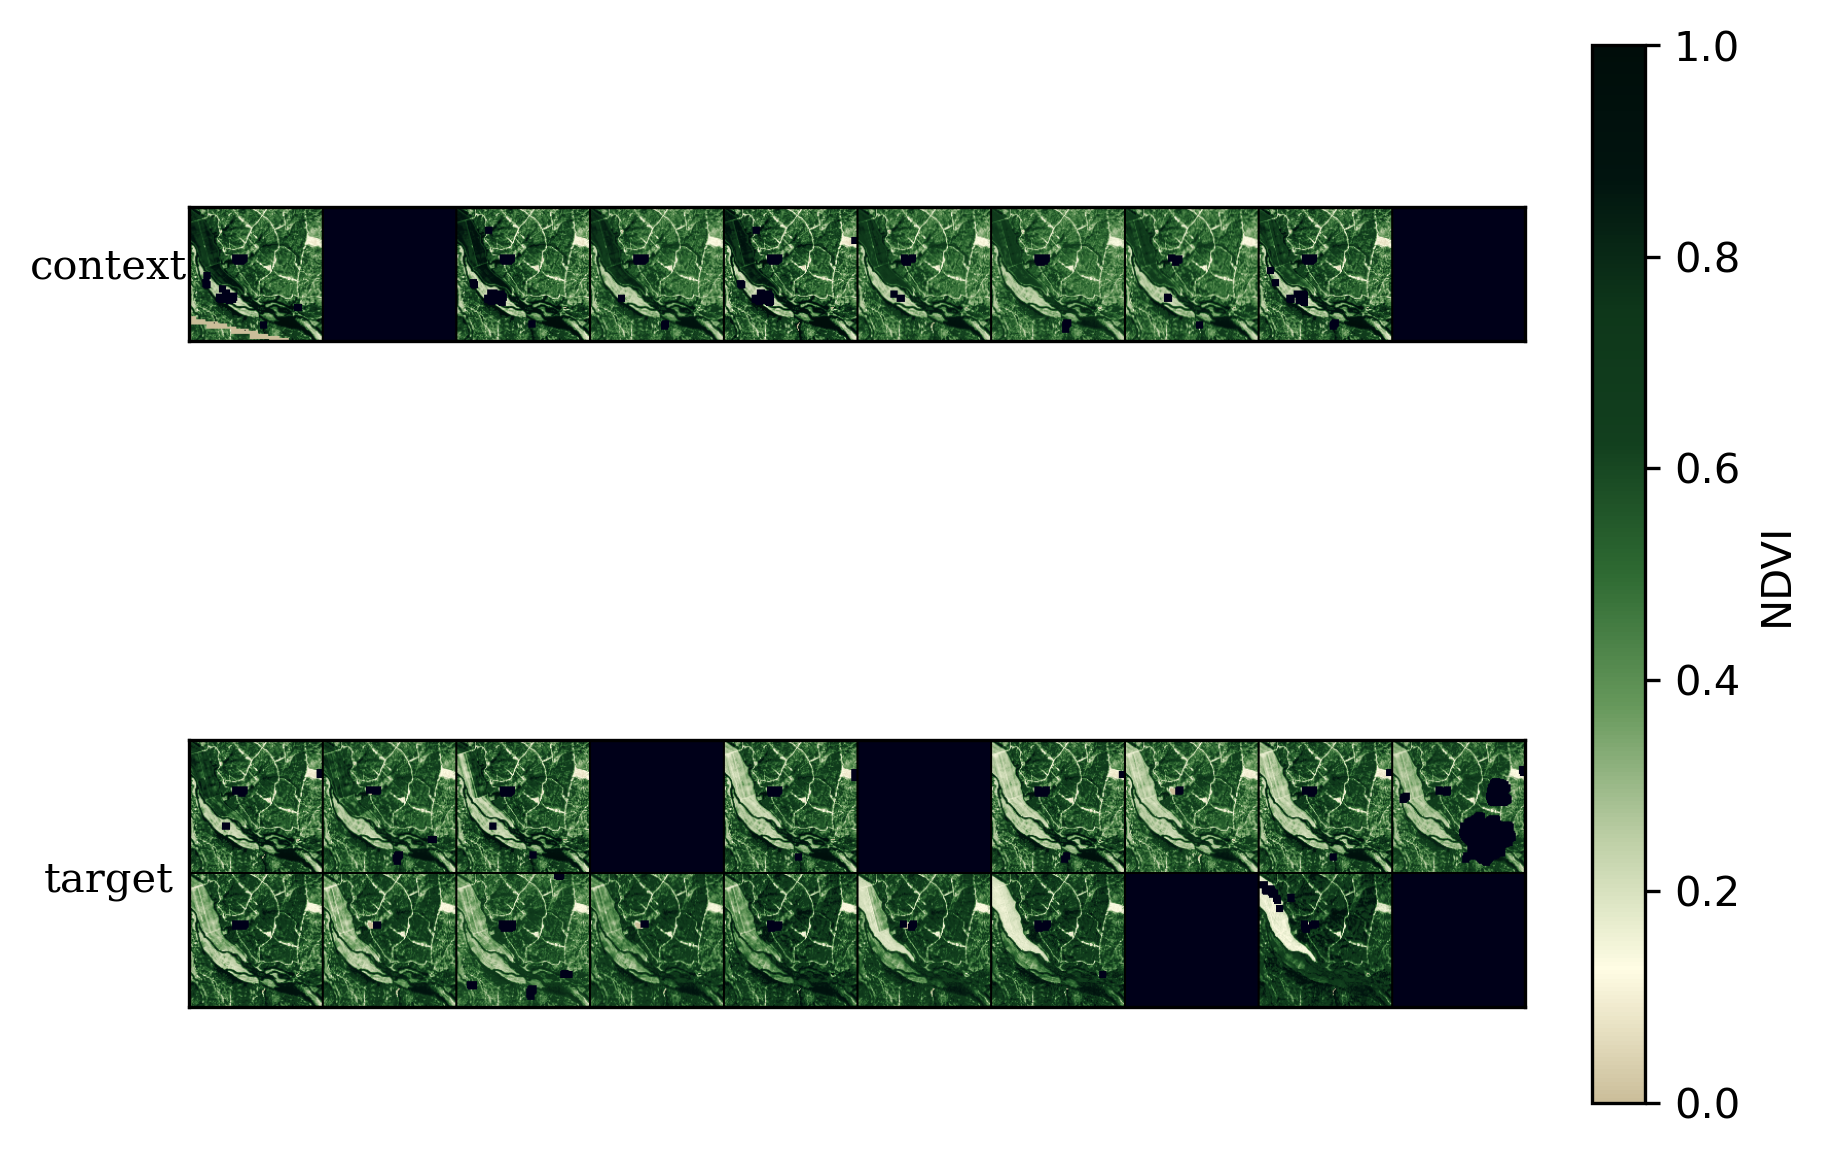

In [4]:
fig_ndvi = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                            target_np=np.expand_dims(highresdynamic_out, axis=0),
                            pred_np=None,
                            layout='N' + config.dataset.layout,
                            variable="ndvi")

## Brief Introduction of Earthformer

Conventionally, Earth system (e.g., weather and climate) forecasting relies on numerical simulation with complex physical models and are hence both expensive in computation and demanding on domain expertise. With the explosive growth of the spatiotemporal Earth observation data in the past decade, data-driven models that apply Deep Learning (DL) are demonstrating impressive potential for various Earth system forecasting tasks. The Transformer as an emerging DL architecture, despite its broad success in other domains, has limited adoption in this area. In this paper, we propose Earthformer, a space-time Transformer for Earth system forecasting. Earthformer is based on a generic, flexible and efficient space-time attention block, named Cuboid Attention. The idea is to decompose the data into cuboids and apply cuboid-level self-attention in parallel. These cuboids are further connected with a collection of global vectors.

Earthformer achieves strong results in synthetic datasets like MovingMNIST and N-body MNIST dataset, and also outperforms non-Transformer models (like ConvLSTM, CNN-U-Net) in SEVIR (precipitation nowcasting) and ICAR-ENSO2021 (El Nino/Southern Oscillation forecasting).

<img src="https://raw.githubusercontent.com/amazon-science/earth-forecasting-transformer/main/figures/teaser.png" width="800"/>


For more details, you may check [our paper](https://assets.amazon.science/89/ad/cb9c23dd4bb69b8e03bbbecdb4b8/earthformer-exploring-space-time-transformers-for-earth-system-forecasting.pdf).

## Load Pretrained Earthformer

We load the Earthformer pretrained on the training set of EarthNet2021. The model is current **rank-1** in [EarthNet2021 leaderboard](https://www.earthnet.tech/docs/ch-leaderboard/).

In [5]:
import torch
import os
from train_cuboid_earthnet import CuboidEarthNet2021PLModule
from earthformer.utils.utils import download

save_dir = "./experiments"

pl_module = CuboidEarthNet2021PLModule(
    total_num_steps=None,
    save_dir="./experiments",
    oc_file=config_file
)

pretrained_checkpoint_url = "https://deep-earth.s3.amazonaws.com/experiments/earthformer/pretrained_checkpoints/earthformer_earthnet2021.pt"
local_checkpoint_path = os.path.join(save_dir, "earthformer_earthnet2021.pt")
download(url=pretrained_checkpoint_url, path=local_checkpoint_path)

state_dict = torch.load(local_checkpoint_path, map_location=torch.device("cpu"))
pl_module.torch_nn_module.load_state_dict(state_dict=state_dict)

/home/ubuntu/.conda/envs/xjshi_dev/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 244M/244M [00:10<00:00, 23.5MiB/s]


<All keys matched successfully>

In [ ]:
pred_seq, loss, in_seq, target_seq, mask = pl_module({"highresdynamic": torch.tensor(np.expand_dims(highresdynamic, axis=0)), 
                                                      "highresstatic": torch.tensor(np.expand_dims(highresstatic, axis=0)),
                                                      "mesodynamic": torch.tensor(np.expand_dims(mesodynamic, axis=0)),
                                                      "mesostatic": torch.tensor(np.expand_dims(mesostatic, axis=0))})

In [ ]:
pred_seq_np = pred_seq.detach().cpu().numpy()

print("loss=", loss.detach().cpu().numpy())

In [ ]:
fig_rgb = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                           target_np=np.expand_dims(highresdynamic_out, axis=0),
                           pred_np=pred_seq_np,
                           layout='N' + config.dataset.layout)

In [ ]:
fig_ndvi = vis_earthnet_seq(context_np=np.expand_dims(highresdynamic_in, axis=0),
                           target_np=np.expand_dims(highresdynamic_out, axis=0),
                           pred_np=pred_seq_np,
                           layout='N' + config.dataset.layout,
                           variable="ndvi")

You may note that some frames in the context and target are empty. This is due to that some observations are very noisy and are masked in the EarthNet2021 dataset. However, the Earthformer is able to predict the frames that have been masked.

## More Details

For more details, check our code-base https://github.com/amazon-science/earth-forecasting-transformer and the [Earthformer paper](https://assets.amazon.science/89/ad/cb9c23dd4bb69b8e03bbbecdb4b8/earthformer-exploring-space-time-transformers-for-earth-system-forecasting.pdf).
